In [ ]:
#pip install opencv-python opencv-contrib-python matplotlib numpy

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

The first step is to find the correspondences between the image book (Figure 2.a) and the
first frame of the video.

In [ ]:
# Load the book image
img_book = cv2.imread("cv_cover.jpg")  
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)
# Load the first frame from the video
cap = cv2.VideoCapture("book.mov")  
ret, frame_video = cap.read()
cap.release()
if not ret:
    raise ValueError("Failed to read the first video frame.")
frame_video_rgb = cv2.cvtColor(frame_video, cv2.COLOR_BGR2RGB)
# Convert images to grayscale
gray_book = cv2.cvtColor(img_book, cv2.COLOR_RGB2GRAY)
gray_video = cv2.cvtColor(frame_video_rgb, cv2.COLOR_RGB2GRAY)
#Now we have 

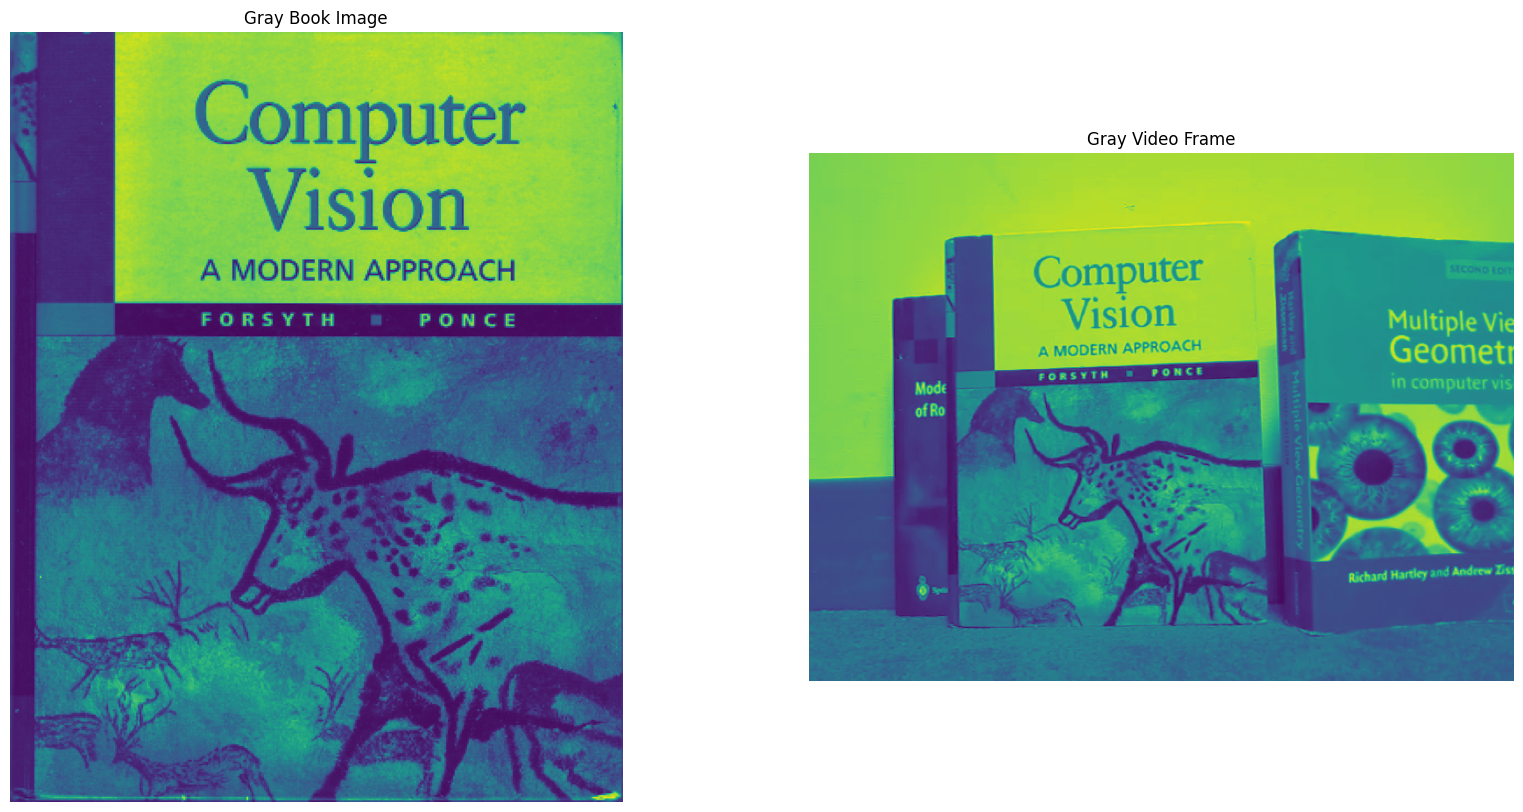

In [ ]:
plt.figure(figsize=(20, 10))  # Set overall figure size
# Plot first image (gray_book)
plt.subplot(1, 2, 1)  # (rows, columns, image_index)
plt.imshow(gray_book)
plt.axis('off')
plt.title('Gray Book Image')
# Plot second image (gray_video)
plt.subplot(1, 2, 2)
plt.imshow(gray_video)
plt.axis('off')
plt.title('Gray Video Frame')
plt.show()


1.1) Getting Correspondences

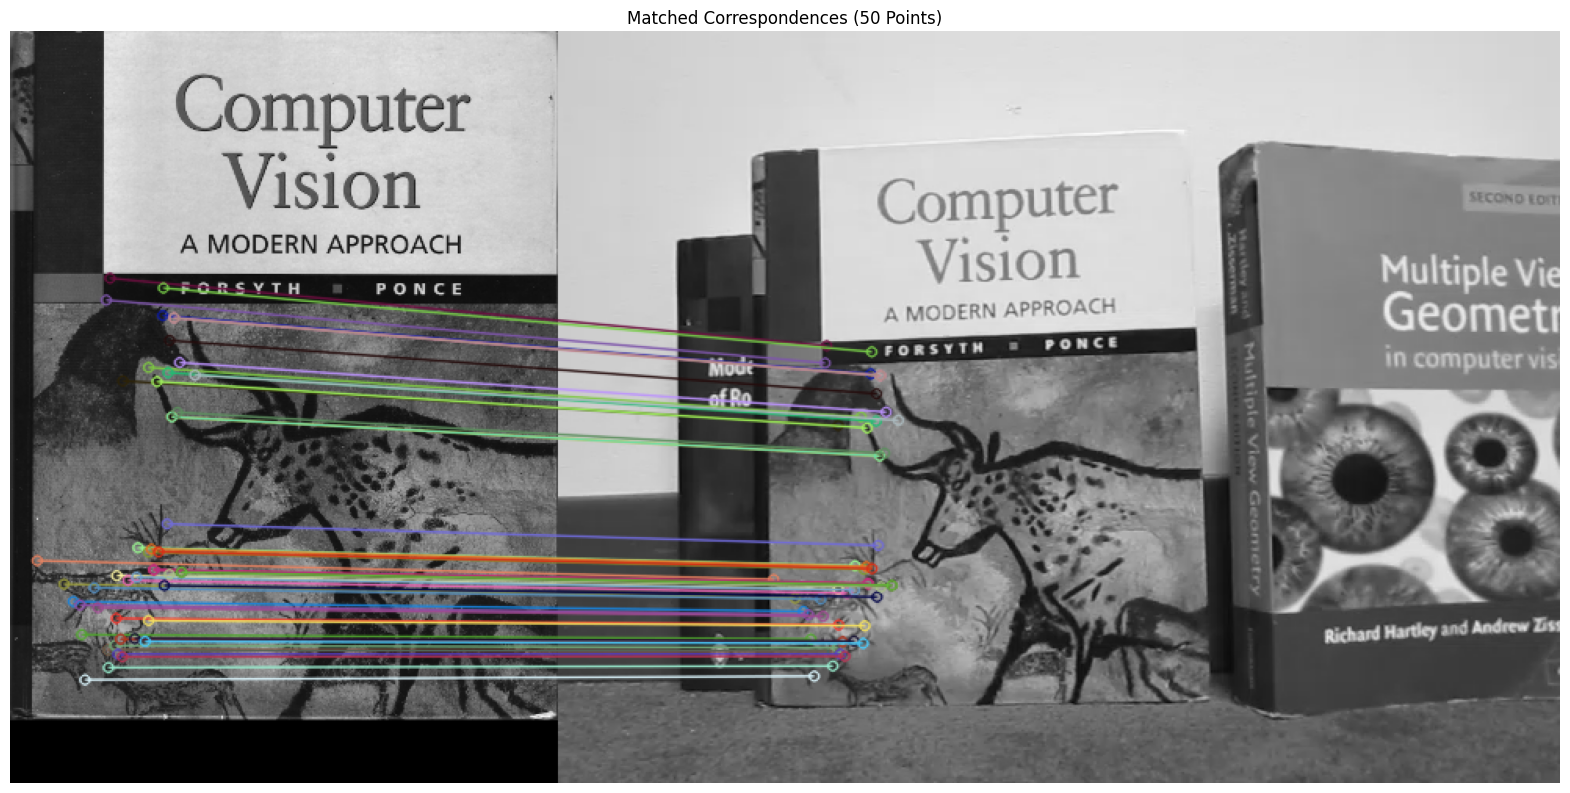

In [ ]:
# Initialize SIFT detector
sift = cv2.SIFT_create()
# Detect keypoints and compute descriptors
kp_book, des_book = sift.detectAndCompute(gray_book, None)
kp_video, des_video = sift.detectAndCompute(gray_video, None)
# Brute-Force Matcher with KNN (k=2)
bf = cv2.BFMatcher()
#finds the two best matches for each descriptor (for applying Lowe's ratio test).
matches = bf.knnMatch(des_book, des_video, k=2)
# Apply ratio test (Lowe's ratio = 0.5)
good_matches = []
for m, n in matches:
    ratio = m.distance / n.distance  # Explicit ratio calculation
    if ratio < 0.5:  # Compare against threshold
        good_matches.append(m)
# Select top 50 matches
selected_matches = good_matches[:50]
# Draw matches
matched_img = cv2.drawMatches(gray_book, kp_book,gray_video, kp_video,selected_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# Display the result
plt.figure(figsize=(20, 10))
plt.imshow(matched_img)
plt.axis('off')
plt.title('Matched Correspondences (50 Points)')
plt.show()

Lowe's Ratio Test is a method introduced by David Lowe in his SIFT paper to filter ambiguous feature matches. It works by comparing the ratio of the distances between the best and second-best matches in the feature descriptor space. A lower ratio number introduces a stricter Filter

1.2) Compute the Homography Parameters  
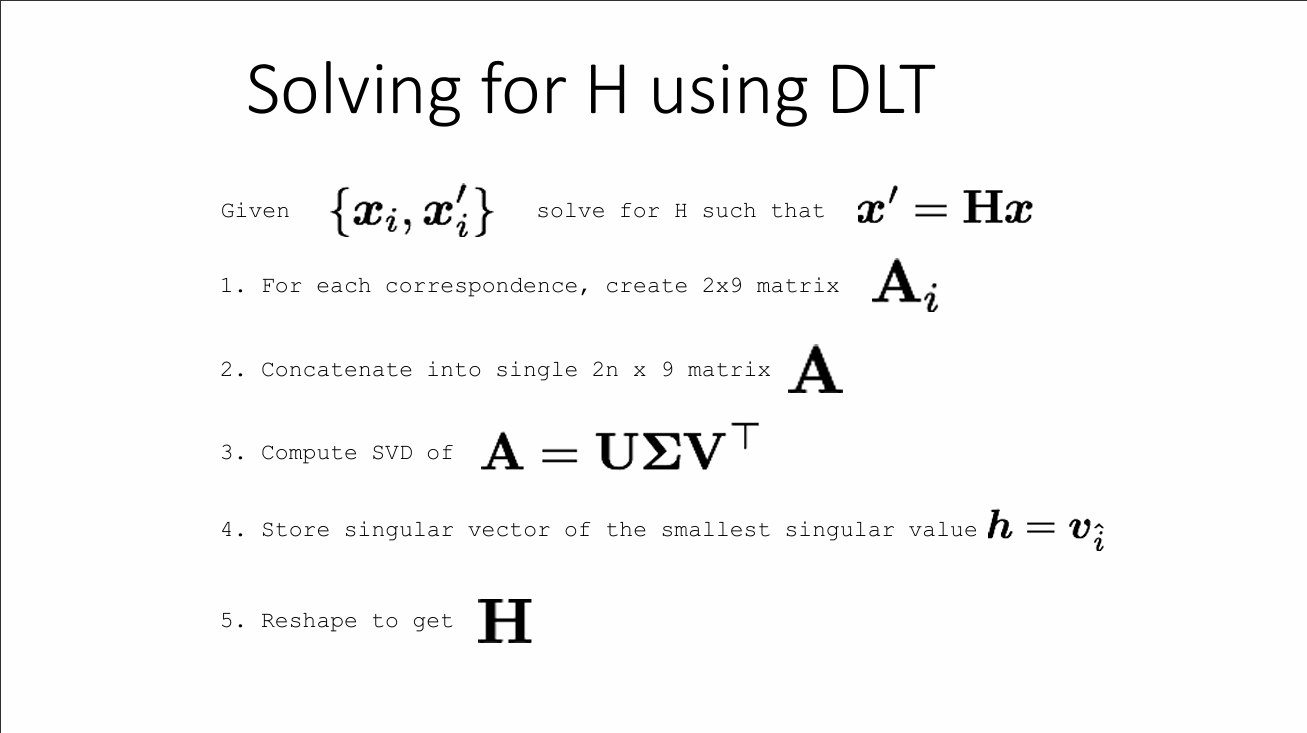

In [ ]:
import numpy as np

def compute_homography(src_pts, dst_pts):
    # Ensure there are at least 4 point correspondences
    assert len(src_pts) >= 4, "At least 4 correspondences src points are required."
    assert len(dst_pts) >= 4, "At least 4 correspondences dst points are required."
    n = src_pts.shape[0]
    # Step 1: Create 2x9 matrix for each correspondence
    A = []
    for i in range(n):
        x, y = src_pts[i]
        xp, yp = dst_pts[i]
        # Construct the matrix for the current point correspondence
        row1 = [x, y, 1, 0, 0, 0, -x * xp, -y * xp, -xp]
        row2 = [0, 0, 0, x, y, 1, -x * yp, -y * yp, -yp]
        A.append(row1)
        A.append(row2)
    # Step 2: Concatenate into a single 2n x 9 matrix
    A = np.array(A)
    # Step 3: Compute the SVD of A
    _, _, Vt = np.linalg.svd(A)
    # Step 4: The singular vector corresponding to the smallest singular value is the last row of Vt
    h = Vt[-1]
    # Step 5: Reshape to get the 3x3 homography matrix
    H = h.reshape(3, 3)
    # Normalize the matrix to ensure H[2, 2] = 1
    H /= H[2, 2]
    return H


Computes the homography matrix H using Direct Linear Transform (DLT).
    Args:
        src_pts: (n, 2) numpy array of source image points.
        dst_pts: (n, 2) numpy array of destination image points.
    Returns:
        H: (3, 3) homography matrix.

In [ ]:
def verify_homography(H, src_pts):
    """
    Projects source points using H and visualizes alignment with destination points.
    """
    # Project source points to destination
    projected_pts = []
    for pt in src_pts:
        p_homo = np.array([pt[0], pt[1], 1.0])
        p_proj = H @ p_homo  #p'=H.p
        p_proj /= p_proj[2]  # Normalize [x'/w y'/w]
        projected_pts.append(p_proj[:2])
    projected_pts = np.array(projected_pts)
    return projected_pts

In [ ]:
# Compute homography
# Extract coordinates of matched keypoints
src_pts = np.float32([kp_book[m.queryIdx].pt for m in selected_matches]).reshape(-1, 2)
dst_pts = np.float32([kp_video[m.trainIdx].pt for m in selected_matches]).reshape(-1, 2)
H = compute_homography(src_pts, dst_pts)
print("Homography matrix using DLT with svd: \n",H)
# Verify alignment
projected_pts=verify_homography(H, src_pts)

Homography matrix using DLT with svd: 
 [[ 7.70758396e-01  6.30419200e-03  1.18679370e+02]
 [-6.37385353e-02  7.82547259e-01  7.76255784e+01]
 [-1.21908833e-04 -6.41583864e-05  1.00000000e+00]]


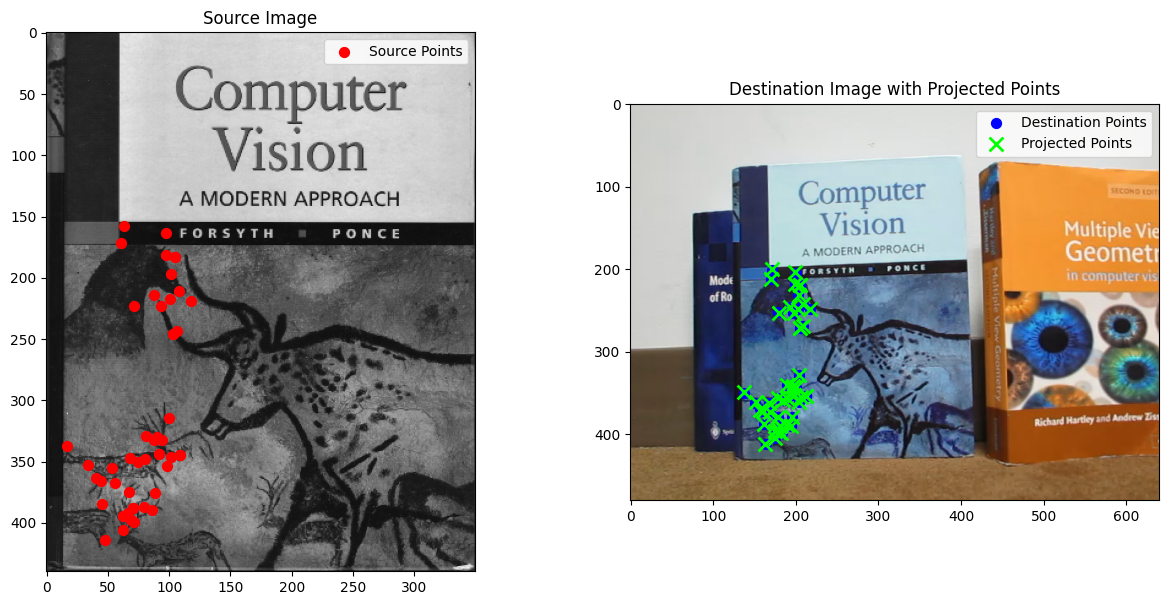

Reprojection Error (Avg): 0.35 pixels


In [ ]:
# Plot results
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img_book)
plt.scatter(src_pts[:, 0], src_pts[:, 1], c='red', s=50, label='Source Points')
plt.title('Source Image')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(frame_video)
plt.scatter(dst_pts[:, 0], dst_pts[:, 1], c='blue', s=50, label='Destination Points')
plt.scatter(projected_pts[:, 0], projected_pts[:, 1], c='lime', marker='x', s=100, linewidth=2, label='Projected Points')
plt.title('Destination Image with Projected Points')
plt.legend()
plt.show()
# Compute reprojection error
error = np.mean(np.linalg.norm(projected_pts - dst_pts, axis=1))
print(f"Reprojection Error (Avg): {error:.2f} pixels")

1.3) Calculate Book Coordinates

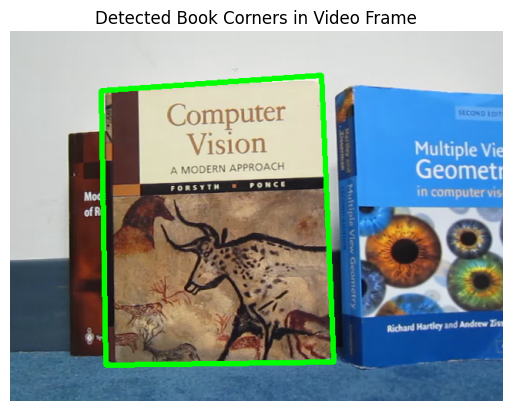

In [ ]:
# Step 1: Define book corners
height, width = img_book.shape[:2]  #get height and width from the img given
corners_book = np.float32([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]]) #get the 4 corners in the img
# Step 2: Project corners to video frame
corners_book_reshaped = corners_book.reshape(-1, 1, 2)
'''Reshapes corners_book into shape (N, 1, 2), which is the required input format for cv2.perspectiveTransform.'''
corners_video = cv2.perspectiveTransform(corners_book_reshaped, H)
'''Applies the homography matrix H to each point in corners_book_reshaped.  p'=H.p '''
corners_video = corners_video.reshape(-1, 2).astype(int)
'''Reshapes the transformed points back to a standard 2D format: shape (N, 2)
Converts the coordinates to integers (since pixel locations are integers)'''
# Step 3: Visualize
frame_with_corners = frame_video_rgb.copy()
cv2.polylines(frame_with_corners, [corners_video], isClosed=True, color=(0, 255, 0), thickness=5) #plot polygon on the video frame
plt.imshow(frame_with_corners)
plt.title('Detected Book Corners in Video Frame')
plt.axis('off')
plt.show()

1.4) Crop AR Video Frames

In [37]:
resized_frames = []

cap = cv2.VideoCapture("ar_source.mov")  
book_aspect = width / height
while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    frame_height, frame_width = frame.shape[:2]
    frame_aspect = frame_width / frame_height

    if frame_aspect > book_aspect:
        new_width = int(book_aspect * frame_height)
        x_start = (frame_width - new_width) // 2
        cropped_frame = frame[:, x_start:x_start+new_width]
    else:
        new_height = int(frame_width / book_aspect)
        y_start = (frame_height - new_height) // 2
        cropped_frame = frame[y_start:y_start+new_height, :]
    resized_frame = cv2.resize(cropped_frame, (width, height))
    # Save to list
    resized_frames.append(resized_frame)
cap.release()


1.5) Overlay the First Frame of the Two Videos

In [ ]:
######